In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import anndata as ad
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_rel
import cellcharter as cc

 captum (see https://github.com/pytorch/captum).
Global seed set to 0


In [3]:
EXCLUDE = ['151507', '151672','151673']
PATIENTS = [['151508', '151509', '151510'], ['151669', '151670', '151671'], ['151674', '151675', '151676']]

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [5]:
PALETTE_METHOD = {
    'DR.SC': "#CFDBE5",
    'SOTIP': "#906CAF",
    'SEDR': "#27AAE1",
    'BayesSpace': "#1C75BC",
    'STAGATE': "#2B3990",
    'UTAG': "#84C3BF",
    'CellCharter': "#ED1C24",
}

for method, color in PALETTE_METHOD.copy().items():
    PALETTE_METHOD[method + ' (CPU)'] = color
    PALETTE_METHOD[method + ' (GPU)'] = color

In [6]:
PALETTE_STEP = {
    'Dimensionality reduction': "#21409A",
    'Spatial embedding': "#006838",
    'Clustering': "#C2B59B"
}

### Figure 1d

In [7]:
methods_joint = {
    'DR.SC': 'results/visium_human_dlpfc/joint/ARI_DR-SC_svg2000_joint.csv',
    'UTAG': 'results/visium_human_dlpfc/joint/ARI_UTAG_hvgs1000_nlatent10_joint.csv',
    'SEDR': 'results/visium_human_dlpfc/joint/ARI_SEDR_feat_hidden2_10_gcn_hidden2_16_pc10_gpu_joint.csv',
    'BayesSpace': 'results/visium_human_dlpfc/joint/ARI_BayesSpace_hvg1000_pc15_gamma3_nrep5000_harmony-group_joint.csv',
    'STAGATE': 'results/visium_human_dlpfc/joint/ARI_STAGATE_hvgs5000_hidden_dim1024_nlatent30_gpu_joint.csv',
    'CellCharter': 'results/visium_human_dlpfc/joint/ARI_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_joint.csv',
}
palette = []
for method in methods_joint.keys():
    for keyword, color in PALETTE_METHOD.items():
        if keyword in method:
            palette.append(color)

In [8]:
df_list = []
for method, path in methods_joint.items():
    df = pd.read_csv(path, index_col=0)
    
    df.columns = np.arange(df.shape[1])
    df['Sample'] = np.stack(df.index.astype(str).str.split("_"))[:, 0]
    df = df[~df['Sample'].isin(EXCLUDE)]
    df['Method'] = [method]*df.shape[0]
    df = df.reset_index(drop=True)
    df_list.append(df)
df = pd.concat(df_list)

df = pd.melt(df, id_vars=['Sample', 'Method'], var_name='Run', value_name='ARI')

In [9]:
df_combined = df.groupby(['Sample', 'Method']).mean().reset_index()

<Figure size 640x480 with 0 Axes>

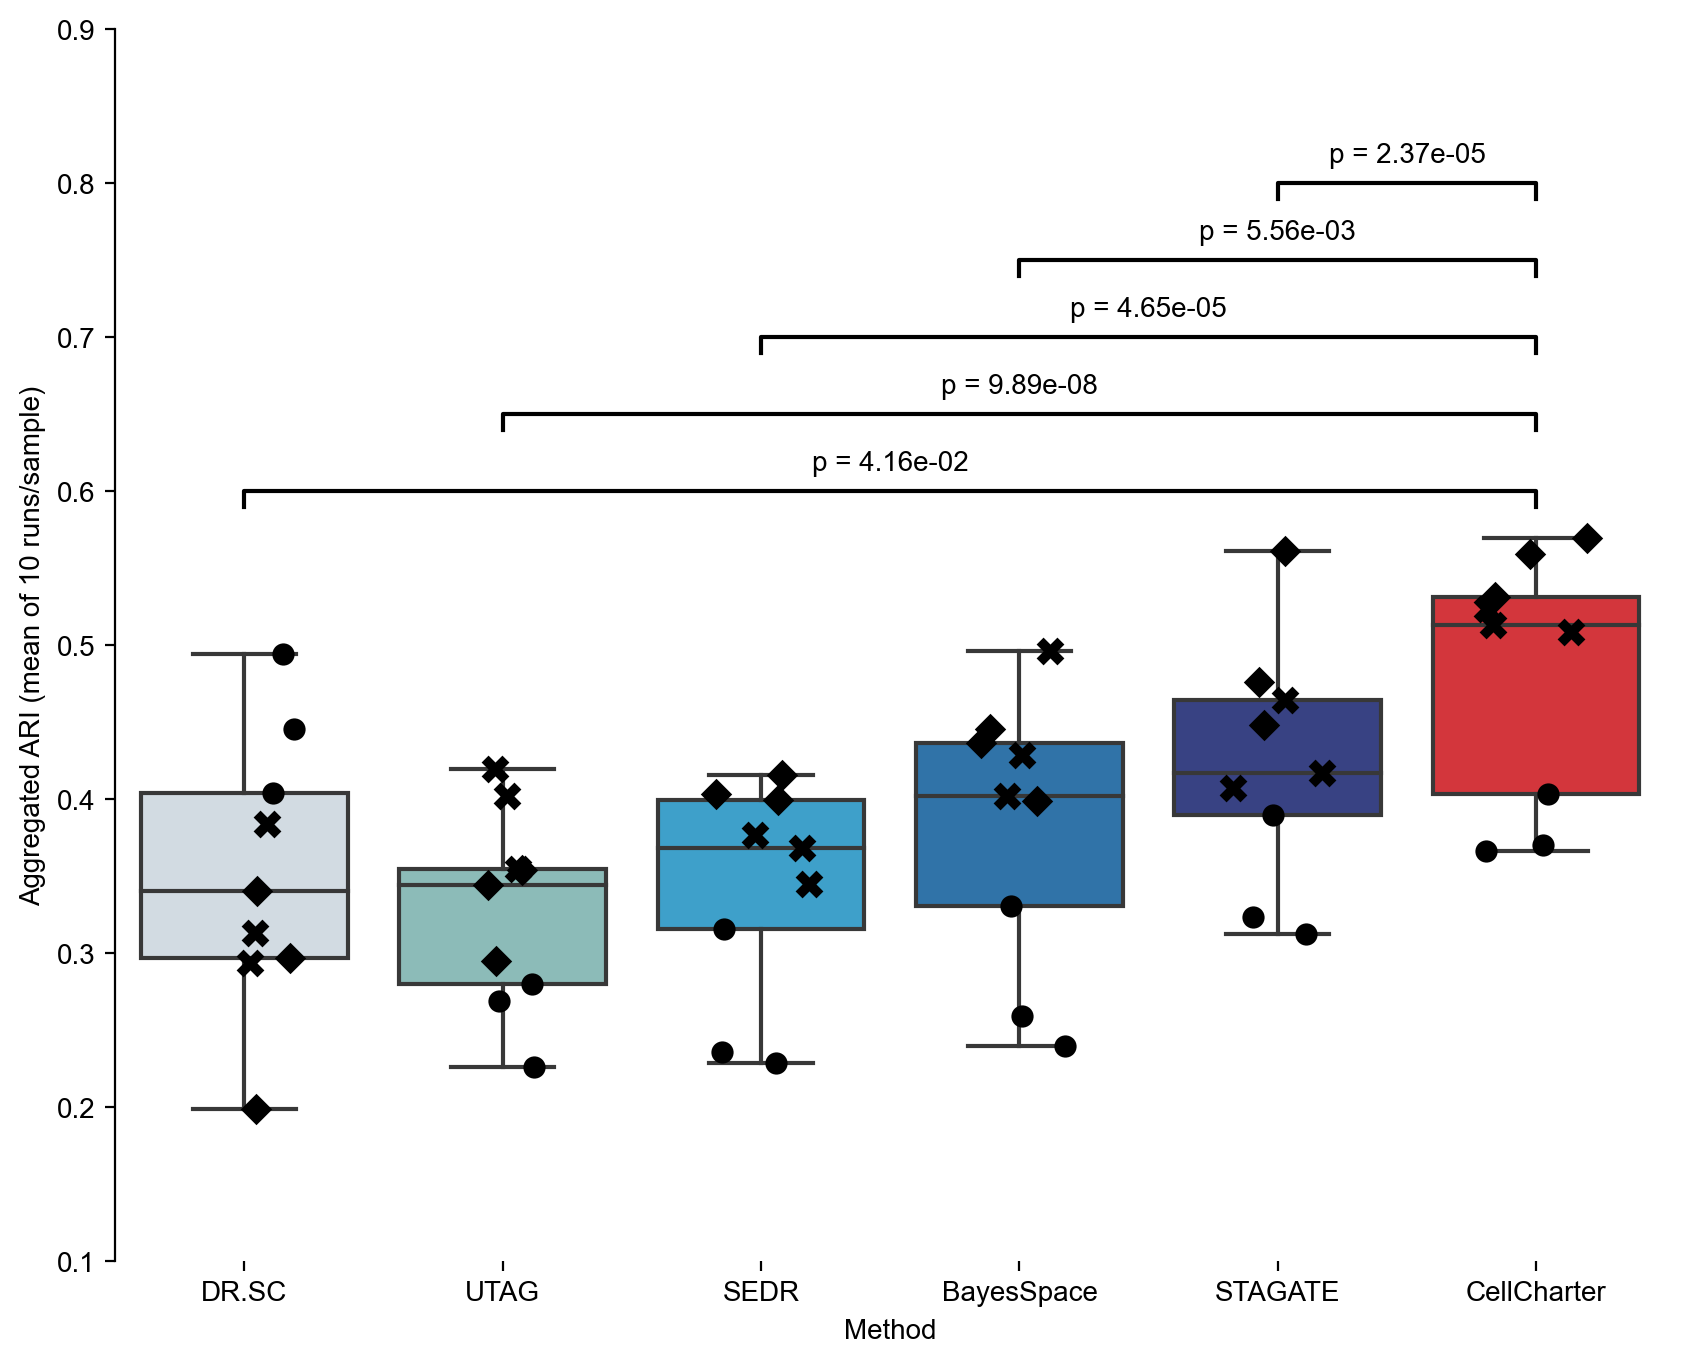

In [10]:
plt.clf()
plt.figure(figsize=(10,8))
ax = sns.boxplot(data=df_combined, x='Method', y='ARI', order=list(methods_joint.keys()), showfliers = False, palette=palette)
for patient, marker in zip(PATIENTS, ['X', 'o', 'D']):
    size = 8
    if marker == 'X':
        size = 10
    ax = sns.stripplot(data=df_combined[df_combined['Sample'].isin(patient)], x='Method', y='ARI', color='black', s=size, order=list(methods_joint.keys()), dodge=True, marker=marker, ax=ax, jitter=0.2)

plt.ylabel('Aggregated ARI (mean of 10 runs/sample)')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

count = 0
for method in ['DR.SC', 'SEDR', 'BayesSpace', 'STAGATE', 'UTAG']:
    pvalue = ttest_rel(df_combined[df_combined['Method'] == 'CellCharter']['ARI'], df_combined[df_combined['Method'] == method]['ARI'])[1]
    if pvalue < 0.05:
        x1, x2 = 5, count 
        y, h, col = df_combined['ARI'].max() +0.02 + 0.05*count, 0.01, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h*2, f"p = {pvalue:.2e}", ha='center', va='bottom', color=col, fontdict={'fontsize':'medium'})
        count += 1

plt.ylim(0.1, 0.9)
plt.show()

### Supplementary Figure 1h

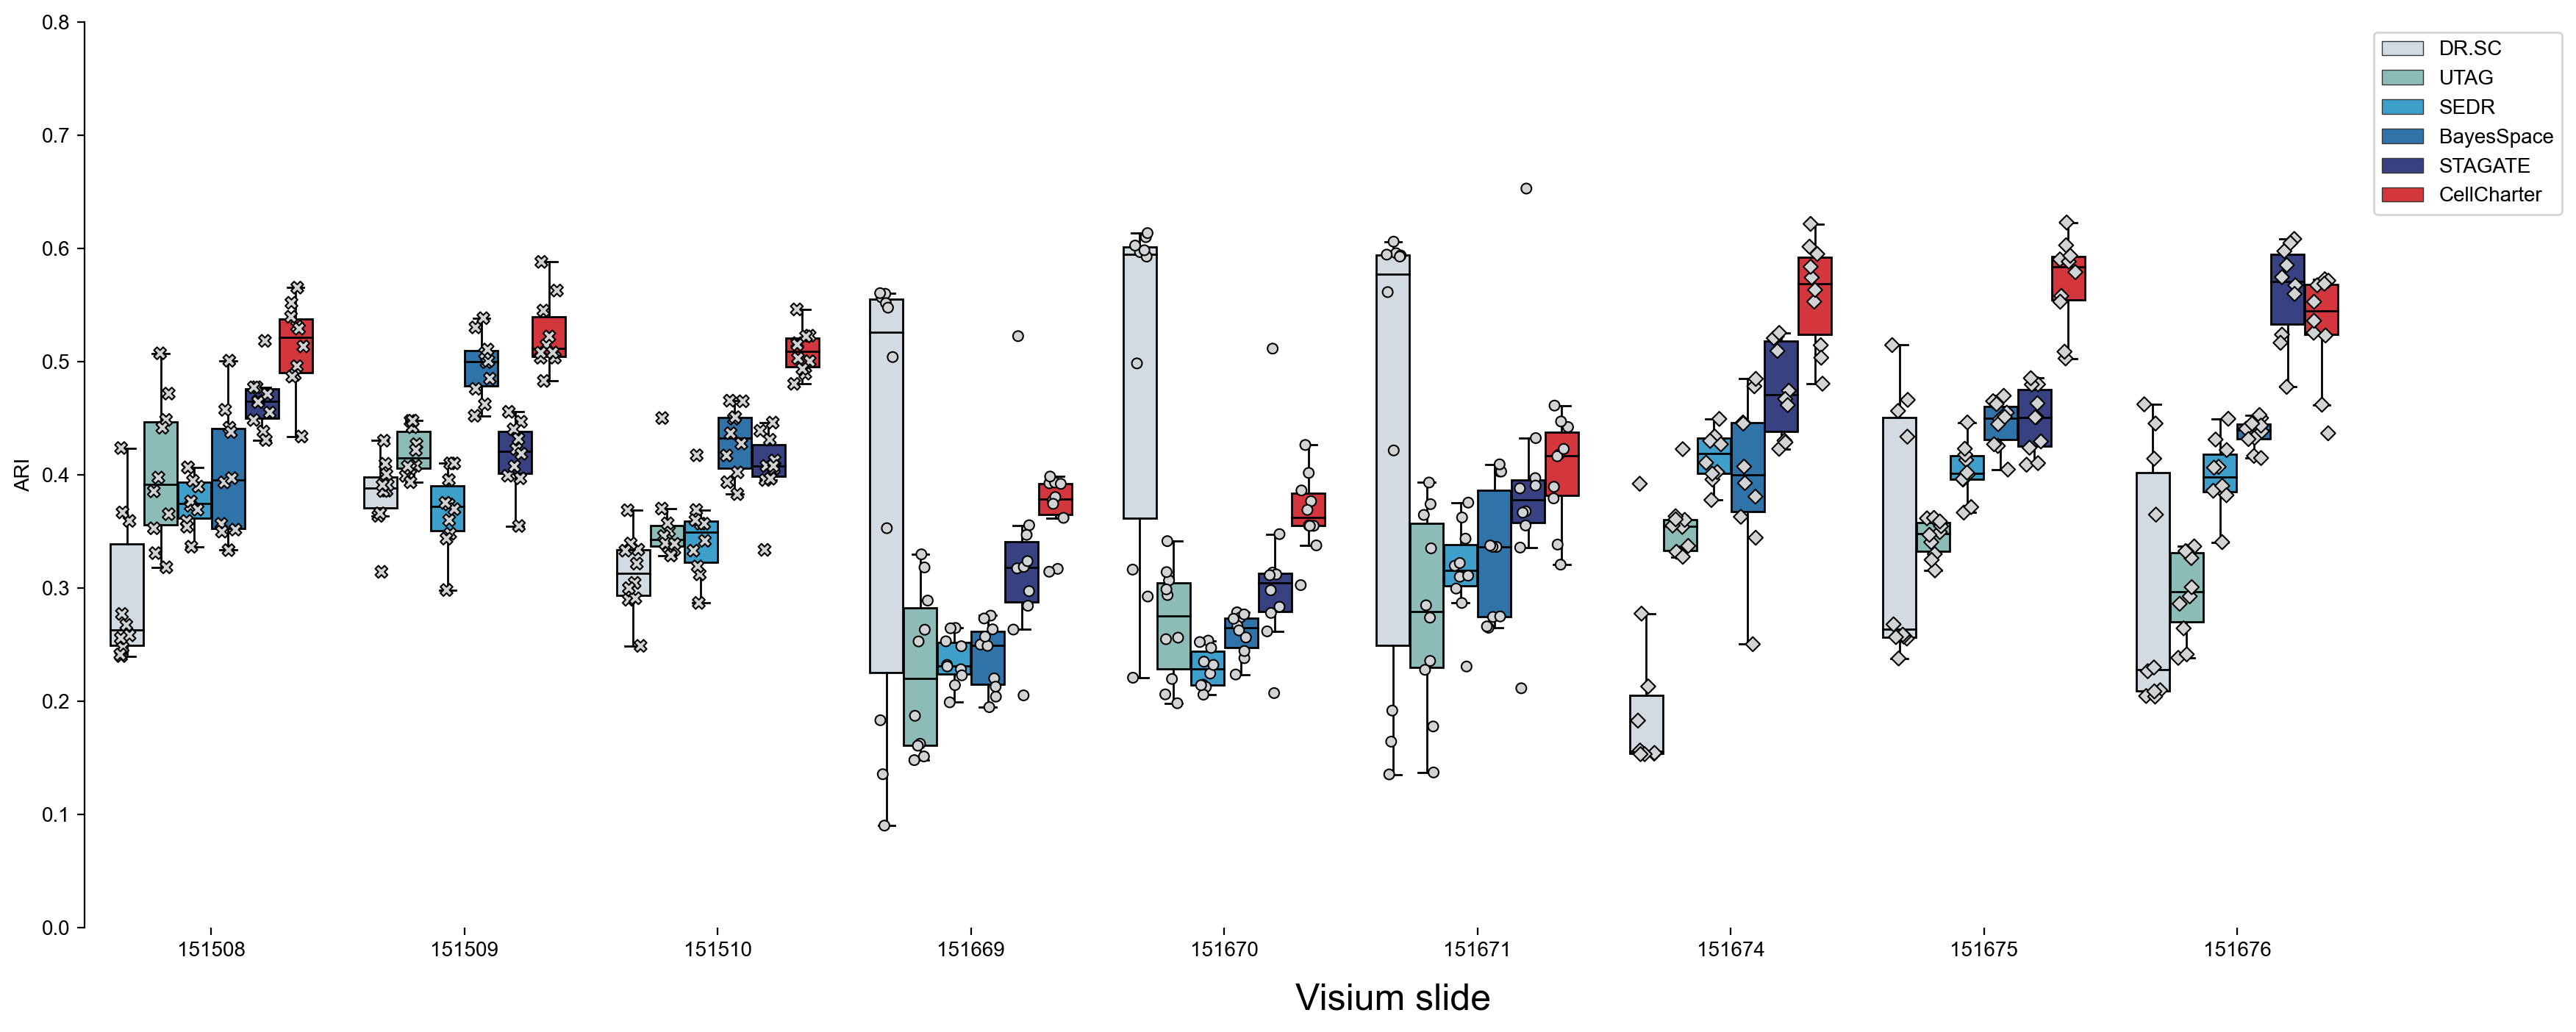

In [11]:
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0)
axs = gs.subplots(sharey=True)
for i, patient, marker in zip([0,1,2], PATIENTS, ['X', 'o', 'D']):
    size = 5
    if marker == 'X':
        size = 6
    axs[i] = sns.boxplot(data=df[df['Sample'].isin(patient)], x='Sample', y='ARI', hue='Method', showfliers = False, palette=palette, ax=axs[i],
                        linewidth=1,
                 boxprops={'edgecolor':'black'},
                 medianprops={'color':'black'},
                 whiskerprops={'color':'black'},
                 capprops={'color':'black'}
)
    axs[i] = sns.stripplot(data=df[df['Sample'].isin(patient)], x='Sample', y='ARI', hue='Method', color='#D1D3D4', edgecolor='black', palette=['#D1D3D4'], linewidth=0.75, dodge=True, s=size, marker=marker, ax=axs[i], jitter=0.2)
    
plt.ylim(0, 0.8)

axs[0].yaxis.set_ticks_position('left')

for ax in axs[1:]:
    ax.set_ylabel("")
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')

for ax in axs:
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.grid(False)
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)

fig.text(0.57, 0.04, 'Visium slide', ha='center', fontsize=18)
handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(handles[0:len(methods_joint)], labels[0:len(methods_joint)],
            loc='upper left',bbox_to_anchor=(1, 1))
plt.show()

### Supplementary Figure 1g

In [12]:
methods_individual = {
    'DR.SC': 'results/visium_human_dlpfc/individual/ARI_DR-SC_svg2000.csv',
    'UTAG': 'results/visium_human_dlpfc/individual/ARI_UTAG_hvgs1000_nlatent10.csv',
    'SEDR': 'results/visium_human_dlpfc/individual/ARI_SEDR_feat_hidden2_10_gcn_hidden2_16_pc100_gpu.csv',
    'BayesSpace': 'results/visium_human_dlpfc/individual/ARI_BayesSpace_hvg1000_pc15_gamma3_nrep5000.csv',
    'STAGATE': 'results/visium_human_dlpfc/individual/ARI_STAGATE_hvgs5000_hidden_dim1024_nlatent30_gpu.csv',
    'SOTIP': 'results/visium_human_dlpfc/individual/ARI_SOTIP_hvgs2000_pcs50_knn30_MEknn50_EMDneighbors500_individual.csv',
    'CellCharter': 'results/visium_human_dlpfc/individual/ARI_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu.csv'
}
palette = []
for method in methods_individual.keys():
    for keyword, color in PALETTE_METHOD.items():
        if keyword in method:
            palette.append(color)

In [13]:
df_list = []
for method, path in methods_individual.items():
    df = pd.read_csv(path, index_col=0)

    df.columns = np.arange(df.shape[1])
    df['Sample'] = np.stack(df.index.astype(str).str.split("_"))[:, 0]
    df = df[~df['Sample'].isin(EXCLUDE)]
    df['Method'] = [method]*df.shape[0]
    df = df.reset_index(drop=True)
    df_list.append(df)
df = pd.concat(df_list)
df = pd.melt(df, id_vars=['Sample', 'Method'], var_name='Run', value_name='ARI')

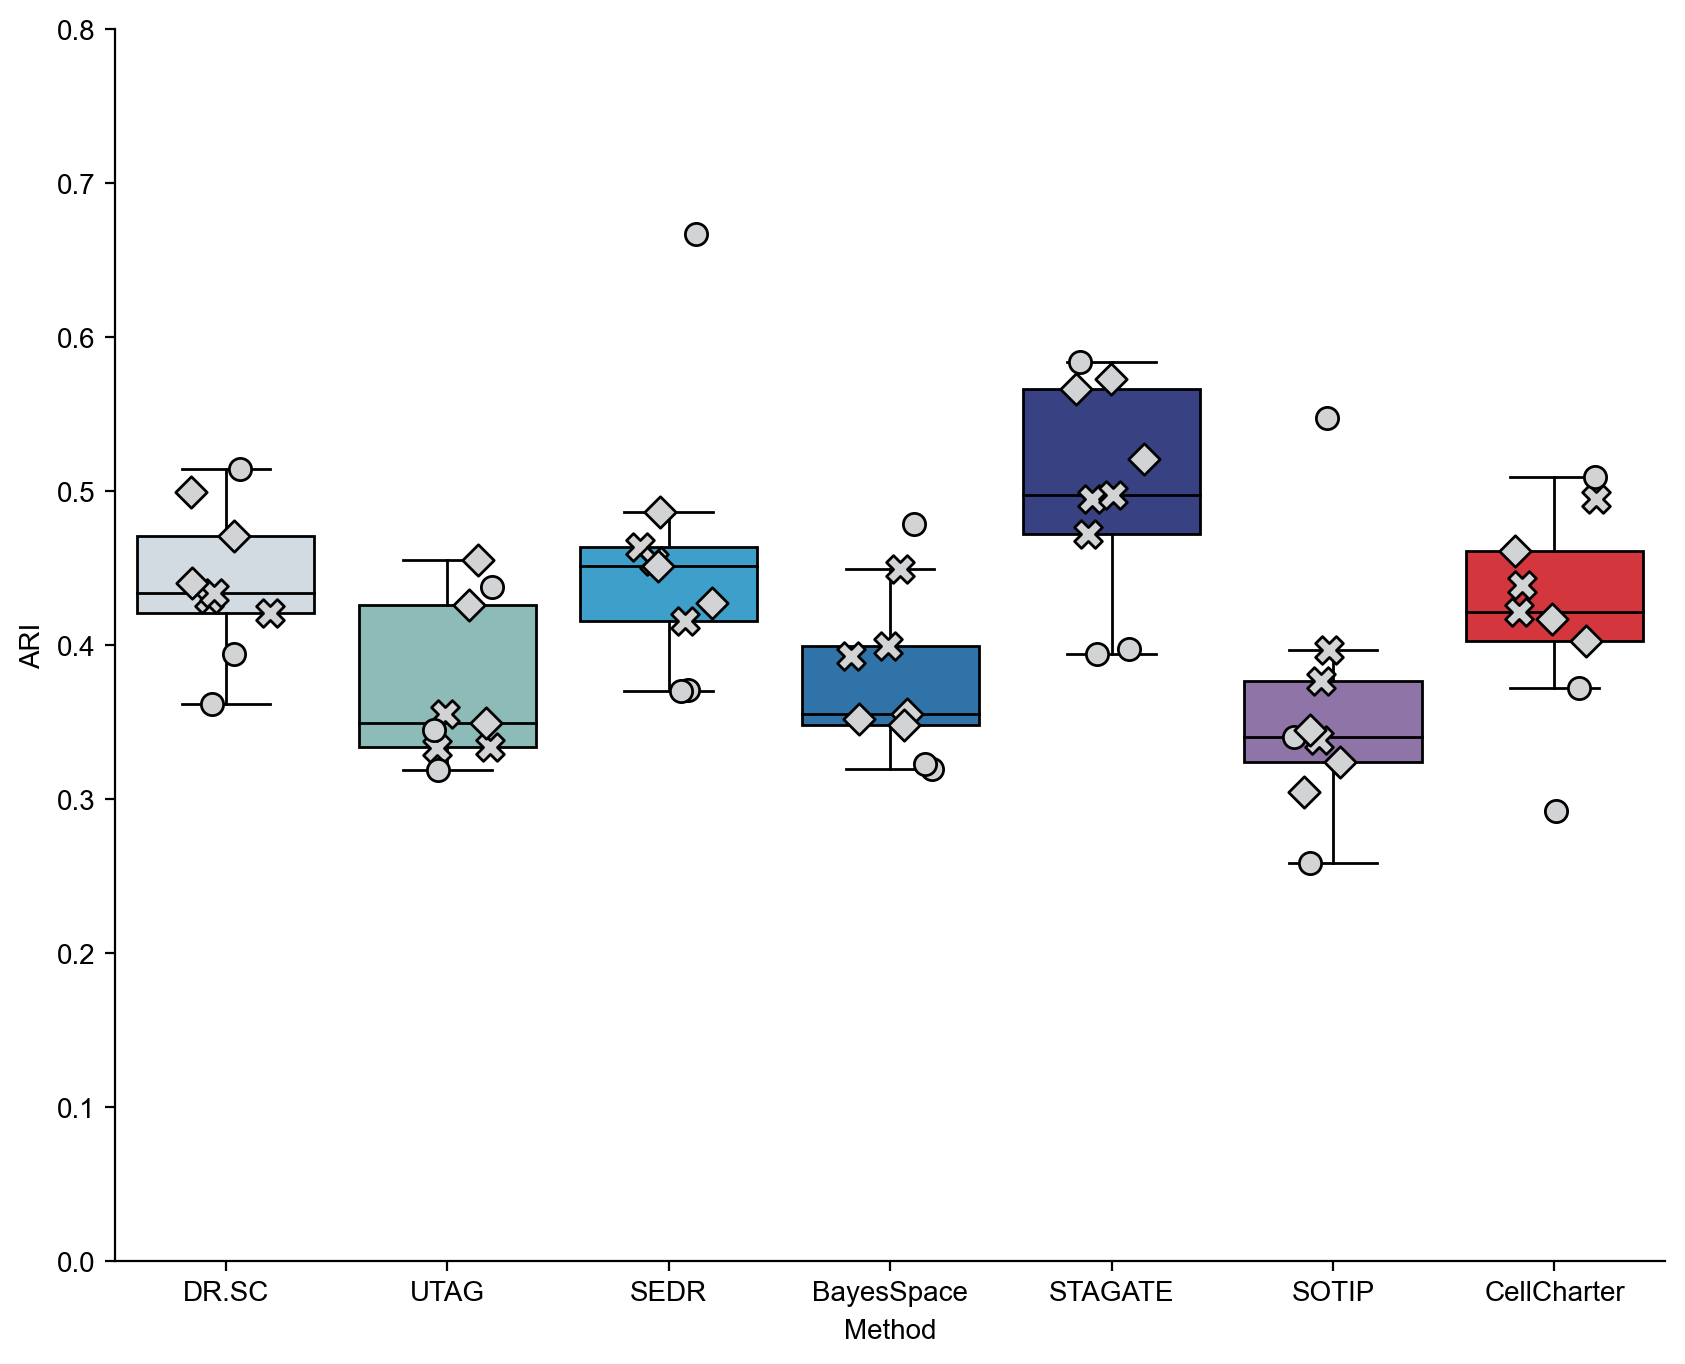

In [14]:
df_combined = df.groupby(['Sample', 'Method']).mean().reset_index()

plt.figure(figsize=(10,8))
ax = sns.boxplot(data=df_combined, 
                 x='Method', 
                 y='ARI', 
                 order=list(methods_individual.keys()), 
                 showfliers = False, 
                 palette=palette,
                 linewidth=1,
                 boxprops={'edgecolor':'black'},
                 medianprops={'color':'black'},
                 whiskerprops={'color':'black'},
                 capprops={'color':'black'})
for patient, marker in zip(PATIENTS, ['X', 'o', 'D']):
    size = 8
    if marker == 'X':
        size = 10
    ax = sns.stripplot(data=df_combined[df_combined['Sample'].isin(patient)], x='Method', y='ARI', color='#D1D3D4', edgecolor='black', linewidth=1,  s=size, order=list(methods_individual.keys()), dodge=True, marker=marker, ax=ax, jitter=0.2)
ax.grid(False)
plt.ylim(0.0, 0.8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

### Figure 1c

In [15]:
def sizes_legend(desired_sizes, ax=None):
    ax = ax or plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    method_handles, size_handles = handles[:11], handles[11:]
    method_labels, size_labels = labels[:11], labels[11:]
    size_labels = np.array([float(l) for l in size_labels])
    desired_handles = [size_handles[np.argmin(np.abs(size_labels - d))] for d in desired_sizes]
    ax.legend(handles=method_handles+desired_handles, 
              labels=method_labels+desired_sizes, 
              title=ax.legend_.get_title().get_text(), 
              loc='upper left', 
              bbox_to_anchor=(1, 1),
              labelspacing=1.05,
              handletextpad=1.3, 
              borderpad=1.2
             )

In [16]:
methods_time = {
    'SEDR (CPU)': 'results/visium_human_dlpfc/time/time_SEDR_feat_hidden2_10_gcn_hidden2_16_pc10_cpu_ncpus4.csv',
    'SEDR (GPU)': 'results/visium_human_dlpfc/time/time_SEDR_feat_hidden2_10_gcn_hidden2_16_pc10_gpu_ncpus4.csv',

    'SOTIP (CPU)': 'results/visium_human_dlpfc/time/time_SOTIP_hvgs2000_nlatent10_knn30_MEknn50_EMDneighbors500_ncpus4.csv',


    'BayesSpace (CPU)': 'results/visium_human_dlpfc/time/time_BayesSpace_hvg1000_pc15_gamma3_nrep5000_harmony-group_ncpus4.csv',

    'STAGATE (CPU)': 'results/visium_human_dlpfc/time/time_STAGATE_hvgs5000_hidden_dim1024_nlatent30_cpu_ncpus4.csv',
    'STAGATE (GPU)': 'results/visium_human_dlpfc/time/time_STAGATE_hvgs5000_hidden_dim1024_nlatent30_gpu_ncpus4.csv',

    'UTAG (CPU)': 'results/visium_human_dlpfc/time/time_UTAG_hvgs1000_nlatent10.csv',

    'CellCharter (CPU)': 'results/visium_human_dlpfc/time/time_CellCharter_hvgs5000_nlatent5_nhoodlayers4_cpu_ncpus4.csv',
    'CellCharter (GPU)': 'results/visium_human_dlpfc/time/time_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_ncpus4.csv',
}

In [17]:
times = None
for method, path in methods_time.items():
    times_df = pd.read_csv(path, index_col=0)
    times_df['Time (min)'] = times_df[[col for col in times_df.columns if col != 'n_samples']].sum(axis=1) / 60
    times_df['Method'] = method
    times_df['N. samples'] = times_df['n_samples']
    times = pd.concat((times, times_df[['N. samples', 'Time (min)', 'Method']]), axis=0)

In [18]:
times_mean = times.groupby(['N. samples', 'Method']).mean().reset_index()
times_mean.index = times_mean[['N. samples', 'Method']]

In [19]:
methods_memory = {    
    'SEDR (CPU)': 'results/visium_human_dlpfc/memory/memory_SEDR_feat_hidden2_10_gcn_hidden2_16_pc100_cpu.csv',
    'SEDR (GPU)': 'results/visium_human_dlpfc/memory/memory_SEDR_feat_hidden2_10_gcn_hidden2_16_pc100_cpu.csv',

    'SOTIP (CPU)': 'results/visium_human_dlpfc/memory/memory_SOTIP_hvgs2000_nlatent10_knn30_MEknn50_EMDneighbors500.csv',
    
    'BayesSpace (CPU)': 'results/visium_human_dlpfc/memory/memory_BayesSpace_hvg1000_pc15_gamma3_nrep5000_harmony-group.csv',
    
    'STAGATE (CPU)': 'results/visium_human_dlpfc/memory/memory_STAGATE_hvgs5000hidden_dim1024_nlatent30_cpu.csv',
    'STAGATE (GPU)': 'results/visium_human_dlpfc/memory/memory_STAGATE_hvgs5000hidden_dim1024_nlatent30_cpu.csv',

    'UTAG (CPU)': 'results/visium_human_dlpfc/memory/memory_UTAG_hvgs1000_nlatent10.csv',
    
    'CellCharter (CPU)': 'results/visium_human_dlpfc/memory/memory_CellCharter_hvgs5000_nlatent5_nhoodlayers4_cpu.csv',
    'CellCharter (GPU)': 'results/visium_human_dlpfc/memory/memory_CellCharter_hvgs5000_nlatent5_nhoodlayers4_cpu.csv'
}

In [20]:
memory = None
for method, path in methods_memory.items():
    memory_df = pd.read_csv(path)
    memory_df.columns = ['N. samples', method]
    memory_df = memory_df[memory_df['N. samples'] > 1]
    memory = memory.merge(memory_df, on='N. samples', how='left') if memory is not None else memory_df
    
memory = pd.melt(memory, id_vars='N. samples', var_name='Method', value_name='Memory (GB)')
memory['Memory (GB)'] /= 1000

In [21]:
benchmark = times.merge(memory, left_on=['N. samples', 'Method'], right_on=['N. samples', 'Method'])

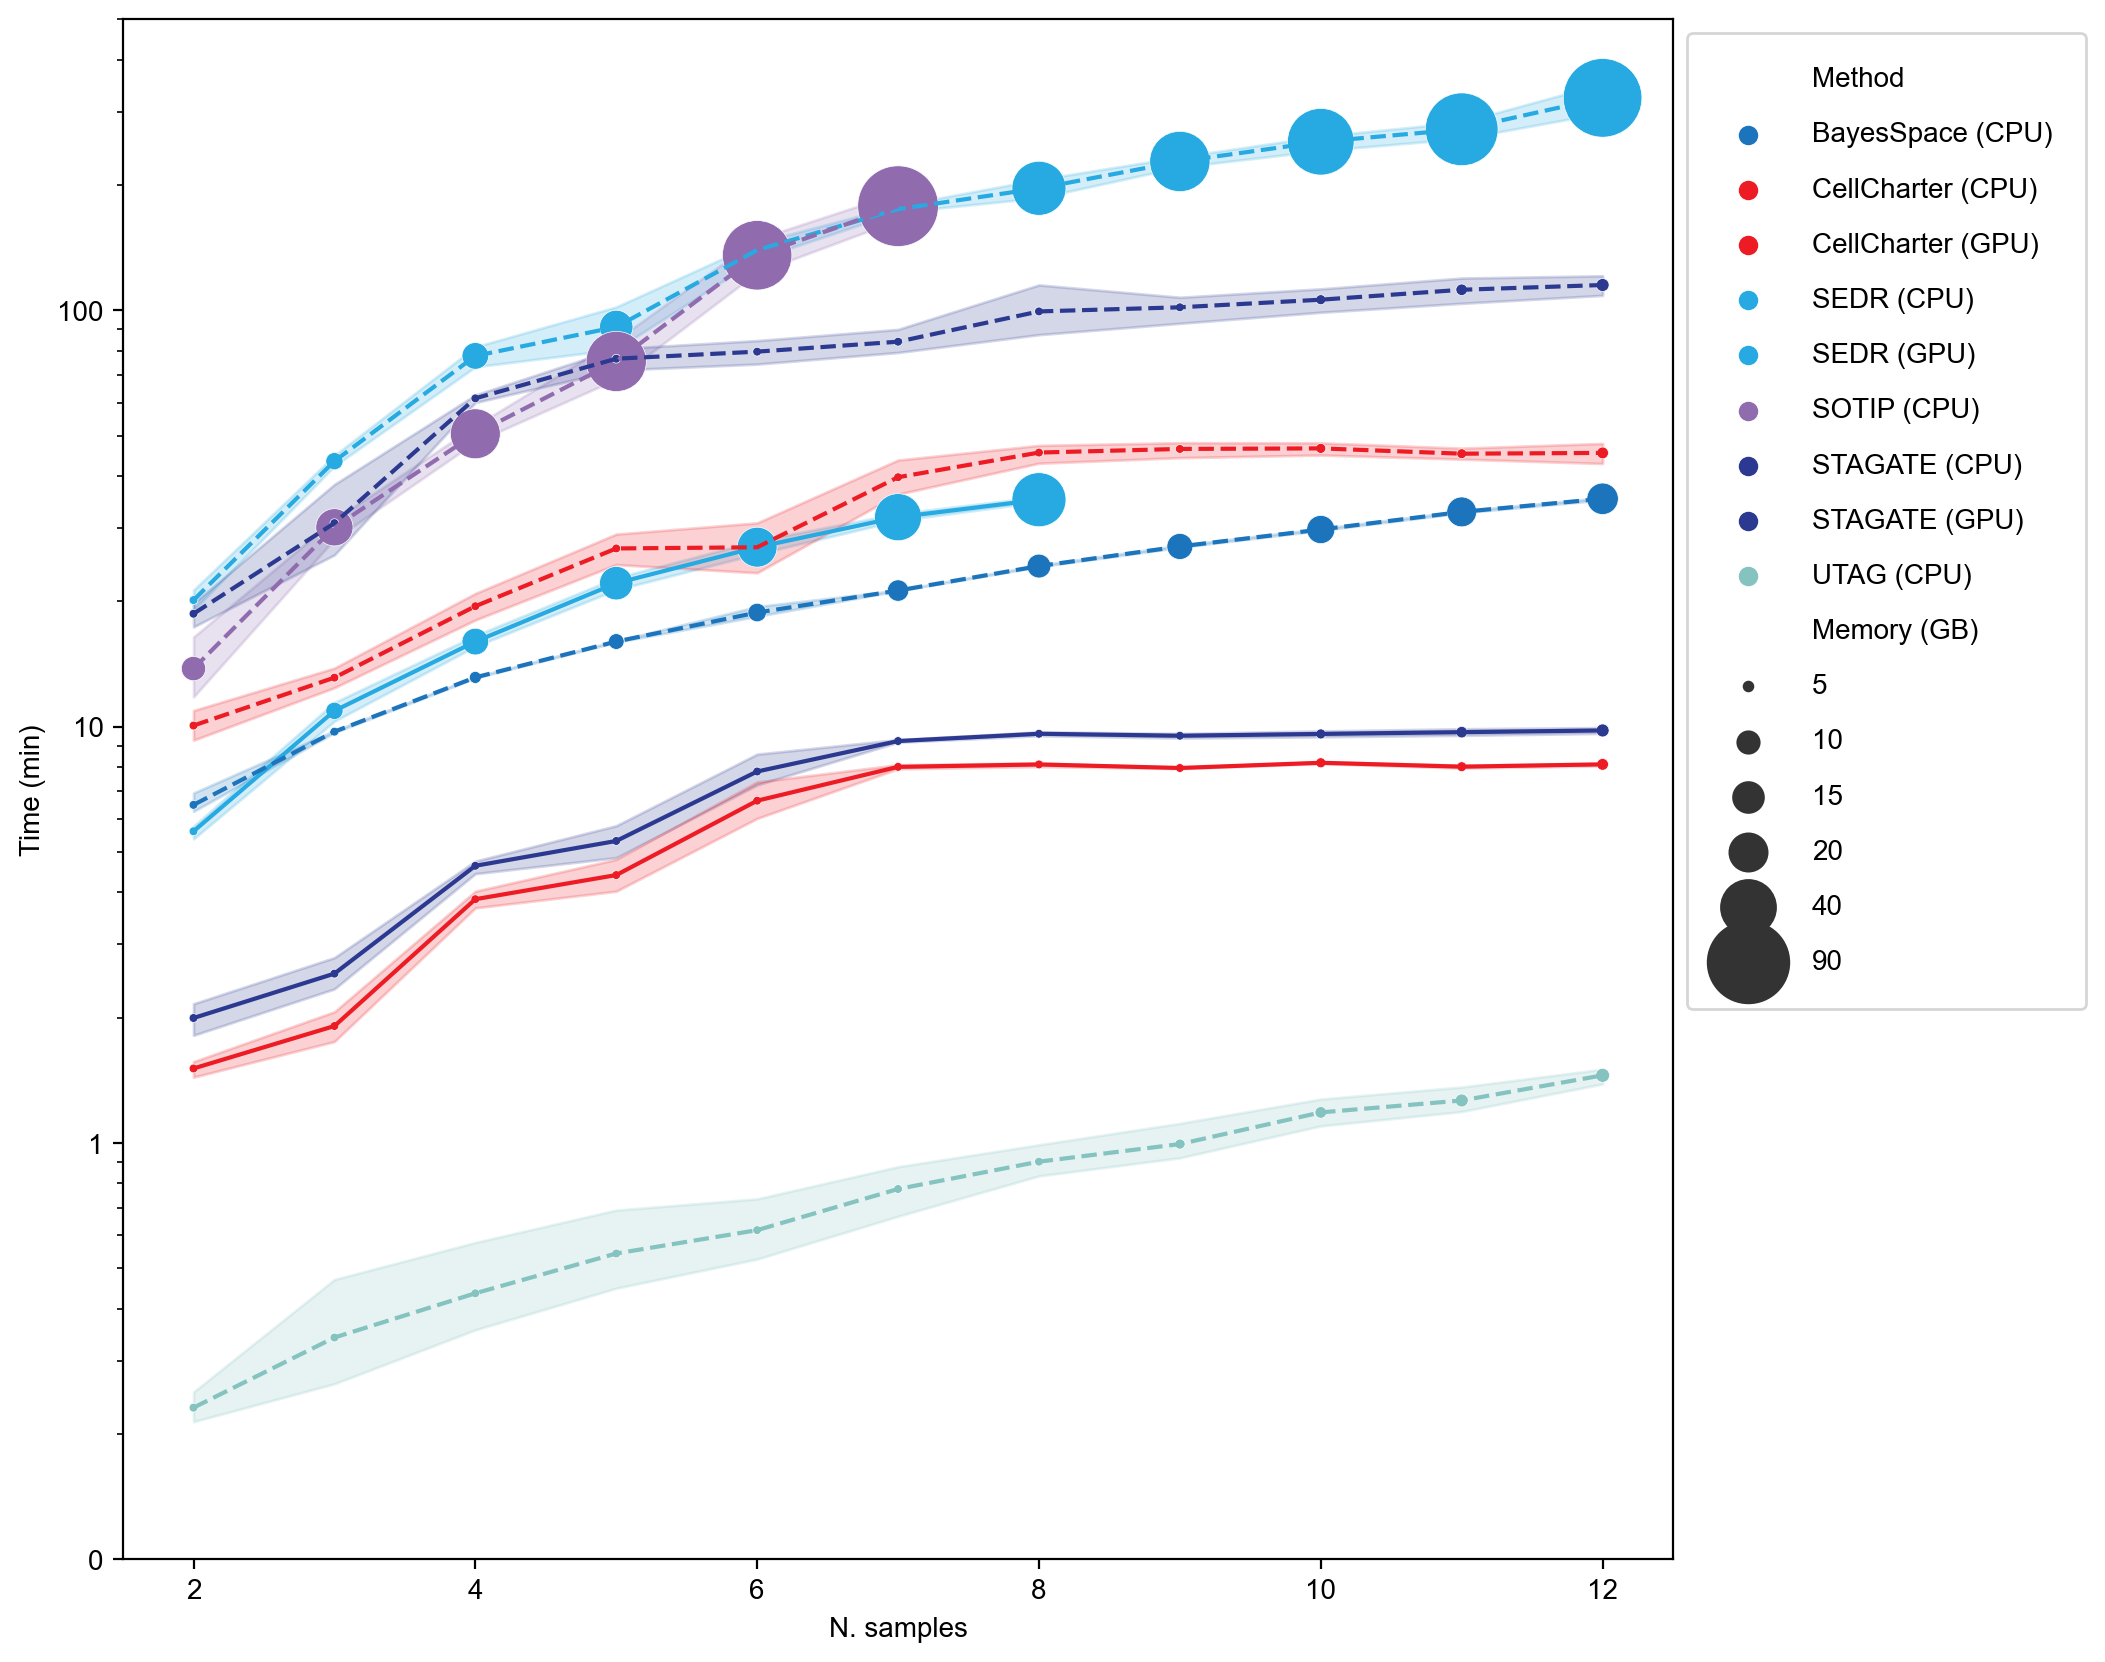

In [22]:
plt.figure(figsize=(10,10))
ax =sns.lineplot(data=benchmark, 
                x='N. samples', 
                y='Time (min)', 
                hue='Method',
                palette=PALETTE_METHOD,
                 legend=False
)
ax = sns.scatterplot(data=times_mean.merge(memory, left_on=['N. samples', 'Method'], right_on=['N. samples', 'Method']), 
                x='N. samples', 
                y='Time (min)', 
                size='Memory (GB)', 
                hue='Method',
                size_norm=(5, 90),
                sizes=(10, 900),
                palette=PALETTE_METHOD, legend='full')

sizes_legend([5, 10, 15, 20, 40, 90], ax)

for i, name in enumerate(methods_memory.keys()):
    if 'CPU' in name:
        ax.lines[i].set_linestyle('--')

plt.grid(False)
plt.yscale('log')
plt.ylim(0.1, 500)
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.show()

### Supplementary Figure 2a

In [23]:
def unify_cols(df):
    df = df.rename(columns={
        'aggregate_neighbors': 'Spatial embedding',
        'spatial_embedding': 'Spatial embedding'
    })

    df['Dimensionality reduction'] = df['load_data'] + df['preprocess'] + df['scvi']
    df['Clustering'] = df['cluster']
    df[['Dimensionality reduction', 'Spatial embedding', 'Clustering']] /= 60
    return df

#### Runtime GPU on DLPFC

In [24]:
times = None
for method in ['STAGATE (GPU)', 'CellCharter (GPU)']:
    path = methods_time[method]
    times_method = pd.read_csv(path, index_col=0)
    times_method[[col for col in times_method.columns if col != 'n_samples']]
    times_method['Method'] = method
    times_method['N. samples'] = times_method['n_samples']
    times_method = unify_cols(times_method)
    
    times = pd.concat((times, times_method), axis=0)

In [25]:
times = times[times['N. samples'] == 12].groupby('Method').mean()

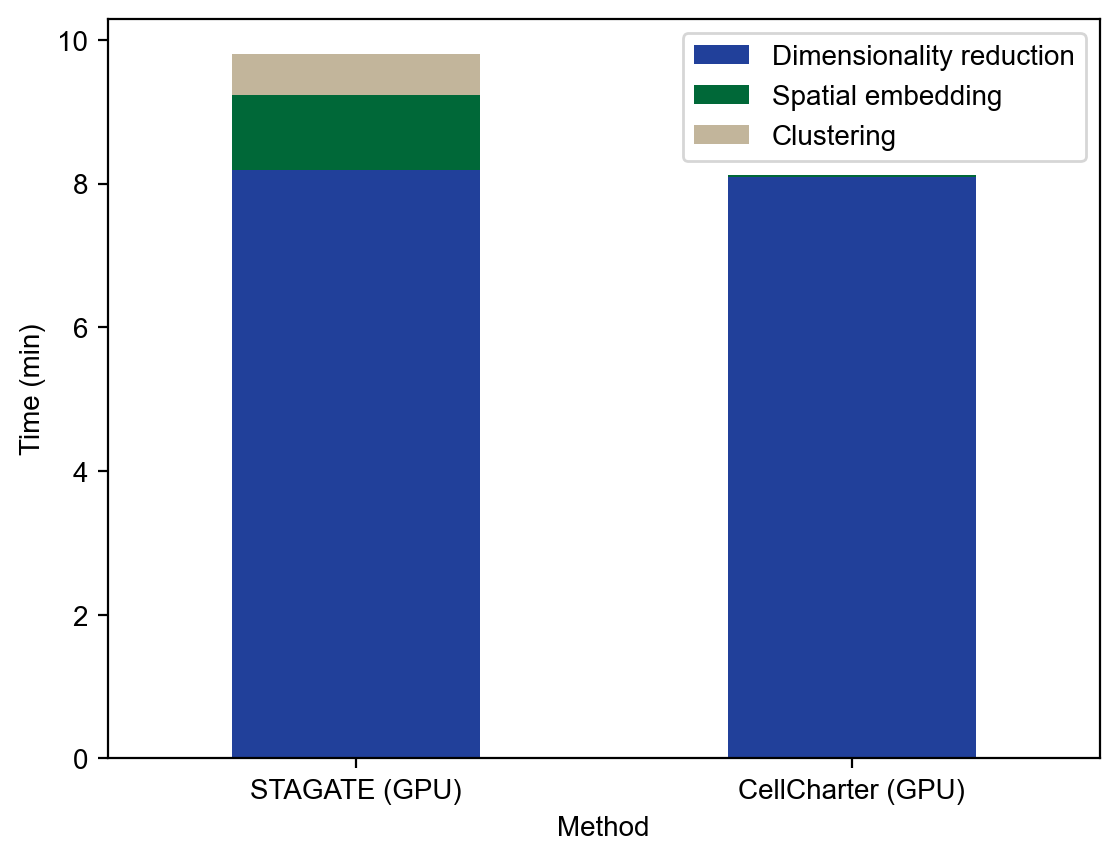

In [26]:
times.loc[['STAGATE (GPU)', 'CellCharter (GPU)'], ['Dimensionality reduction', 'Spatial embedding', 'Clustering']].plot.bar(stacked=True, color=PALETTE_STEP)
plt.ylabel('Time (min)')
plt.xticks(rotation=0)
plt.show()

#### Runtime CPU on DLPFC

In [27]:
times = None
for method in ['STAGATE (CPU)', 'CellCharter (CPU)']:
    path = methods_time[method]
    times_method = pd.read_csv(path, index_col=0)
    times_method[[col for col in times_method.columns if col != 'n_samples']]
    times_method['Method'] = method
    times_method['N. samples'] = times_method['n_samples']
    times_method = unify_cols(times_method)
    
    times = pd.concat((times, times_method), axis=0)

In [28]:
times = times[times['N. samples'] == 12].groupby('Method').mean()

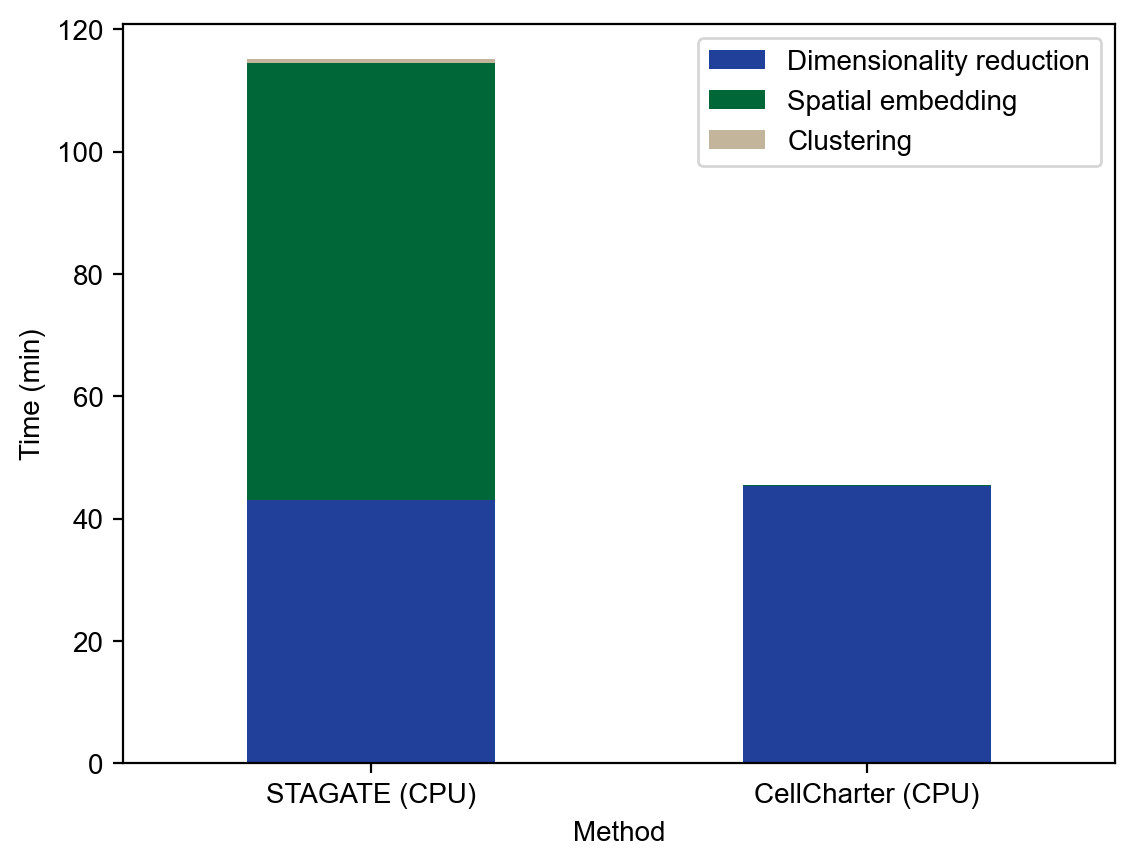

In [29]:
times.loc[['STAGATE (CPU)', 'CellCharter (CPU)'], ['Dimensionality reduction', 'Spatial embedding', 'Clustering']].plot.bar(stacked=True, color=PALETTE_STEP)
plt.ylabel('Time (min)')
plt.xticks(rotation=0)
plt.show()

### Figure 1j

In [30]:
times = pd.read_csv('results/codex_mouse_spleen/time_codex_spleen_CellCharter_STAGATE_gpu.csv', index_col=0)
times /= 60

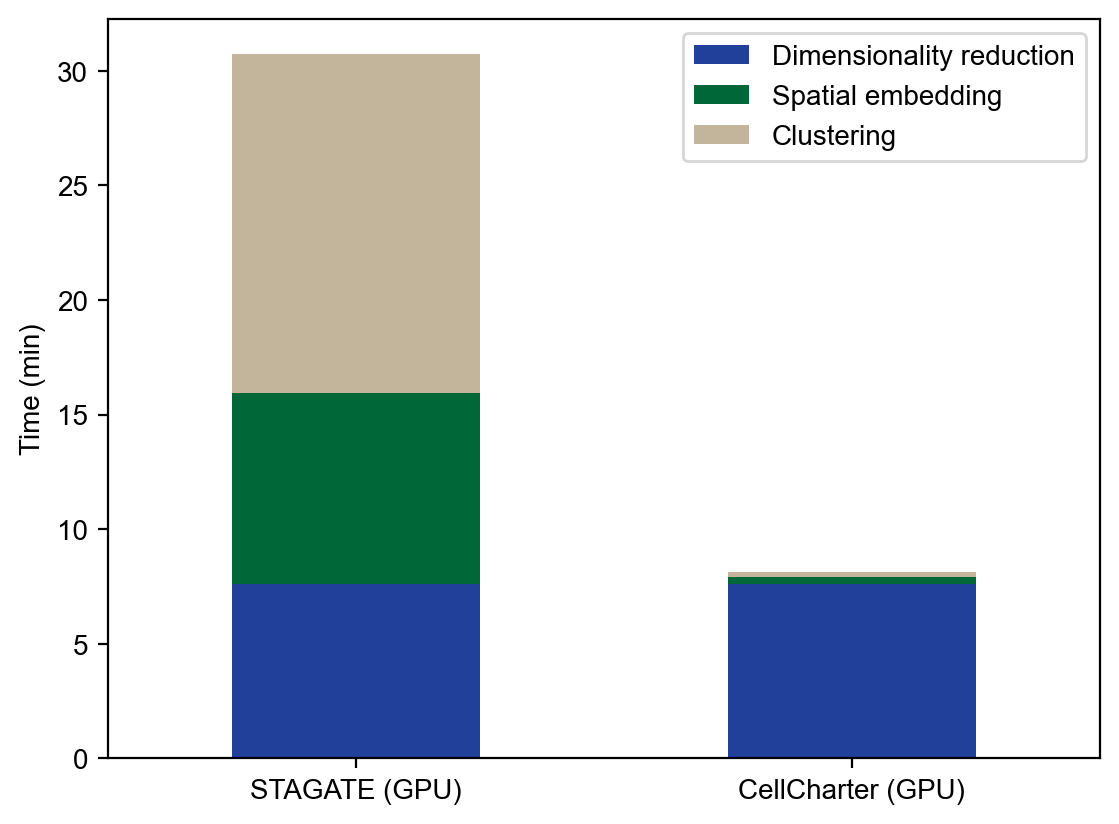

In [31]:
times.loc[['STAGATE (GPU)', 'CellCharter (GPU)'], ['Dimensionality reduction', 'Spatial embedding', 'Clustering']].plot.bar(stacked=True, color=PALETTE_STEP)
plt.ylabel('Time (min)')
plt.xticks(rotation=0)
plt.show()

In [32]:
times = pd.read_csv('results/codex_mouse_spleen/time_codex_spleen_CellCharter_STAGATE_cpu.csv', index_col=0)
times /= 60

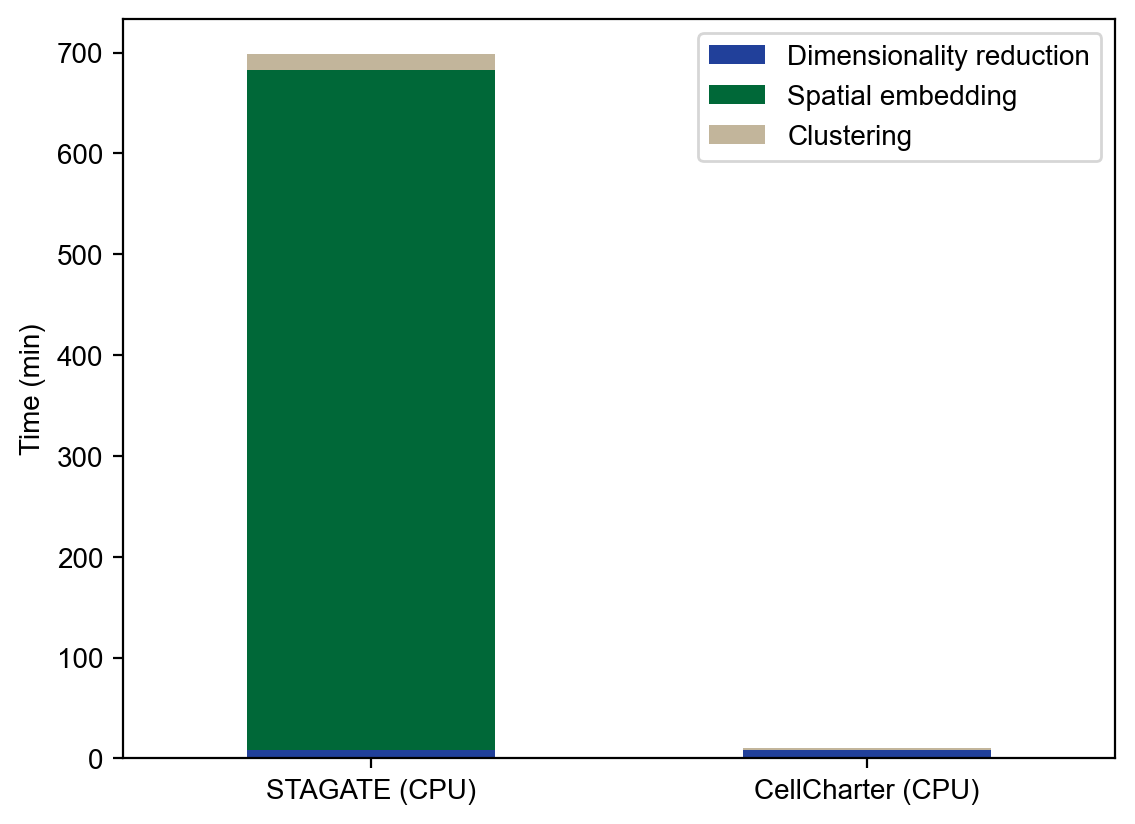

In [33]:
times.loc[['STAGATE (CPU)', 'CellCharter (CPU)'], ['Dimensionality reduction', 'Spatial embedding', 'Clustering']].plot.bar(stacked=True, color=PALETTE_STEP)
plt.ylabel('Time (min)')
plt.xticks(rotation=0)
plt.show()

### Figure 1e

In [34]:
LABELS_PATHS = {
    'DR.SC': 'results/visium_human_dlpfc/labels/labels_DR-SC_svg2000_joint.csv',
    'BayesSpace': 'results/visium_human_dlpfc/labels/labels_BayesSpace_hvg1000_pc15_gamma3_nrep5000_harmony-group_joint.csv',
    'SEDR': 'results/visium_human_dlpfc/labels/labels_SEDR_feat_hidden2_10_gcn_hidden2_16_pc10_gpu_joint.csv',
    'STAGATE': 'results/visium_human_dlpfc/labels/labels_STAGATE_hvgs5000_hidden_dim1024_nlatent30_gpu_joint.csv',
    'UTAG': 'results/visium_human_dlpfc/labels/labels_UTAG_hvgs1000_nlatent10_joint.csv',
    'CellCharter': 'results/visium_human_dlpfc/labels/labels_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_joint.csv'
}

In [35]:
LABELS_REPLACEMENTS = {
    'DR.SC': {
        6: 0,
        3: 1,
        2: 2,
        0: 3,
        4: 4
    },
    'BayesSpace': {
        3: 0,
        6: 1,
        4: 2,
        0: 3,
        5: 4,
        1: 5,
        2: 6
    },
    'SEDR': {
        6: 0,
        1: 1,
        3: 2,
        2: 3,
        0: 4,
        4: 5,
        5: 6,
        
    },
    'STAGATE': {
        7: 0,
        1: 1,
        2: 2,
        3: 3,
        5: 4,
        4: 5,
        6: 6
    },
    'UTAG': {
        3: 0,
        2: 1,
        0: 2,
        5: 3,
        4: 4,
        1: 5,
    },
    'CellCharter': {
        4: 0,
        1: 1,
        5: 2,
        2: 3,
        0: 4, 
        3: 5,
        6: 6,
    },
    'Manual annotation': {
        'WM': 0,
        'Layer6': 1,
        'Layer5': 2,
        'Layer4': 3,
        'Layer3': 4,
        'Layer2': 5,
        'Layer1': 6,
        'NA': 7,
        
    }
}

In [36]:
adata = ad.read_h5ad('data/visium_human_dlpfc/preprocessed_h5ad/151675.h5ad')
adata.obsm['spatial'][:, 1] = np.max(adata.obsm['spatial'][:, 1]) - adata.obsm['spatial'][:, 1]

for method, path in LABELS_PATHS.items():
    labels = pd.read_csv(path, index_col=0)
    labels = labels[labels['sample'] == 151675]
    ARIs = [adjusted_rand_score(labels[col][~adata.obs['sce.layer_guess'].isna()], adata.obs['sce.layer_guess'][~adata.obs['sce.layer_guess'].isna()]) for col in labels.columns if col.startswith('cluster_')]
    best_run = np.argmax(ARIs)
    labels = labels[np.array([col for col in labels.columns if col.startswith('cluster_')])[best_run]]
    labels = labels.rename(method)
    adata.obs = adata.obs.join(labels)
    adata.obs[method] = pd.Categorical(adata.obs[method])
    print(method, 'ARI:', ARIs[best_run])

# Replace column name sce.layer_guss with 'Manual annotation'
adata.obs = adata.obs.rename(columns={'sce.layer_guess': 'Manual annotation'})

DR.SC ARI: 0.5146243208144593
BayesSpace ARI: 0.449148986161425
SEDR ARI: 0.44630845171844064
STAGATE ARI: 0.4854020442699266
UTAG ARI: 0.3619678638006145
CellCharter ARI: 0.6229537350228461


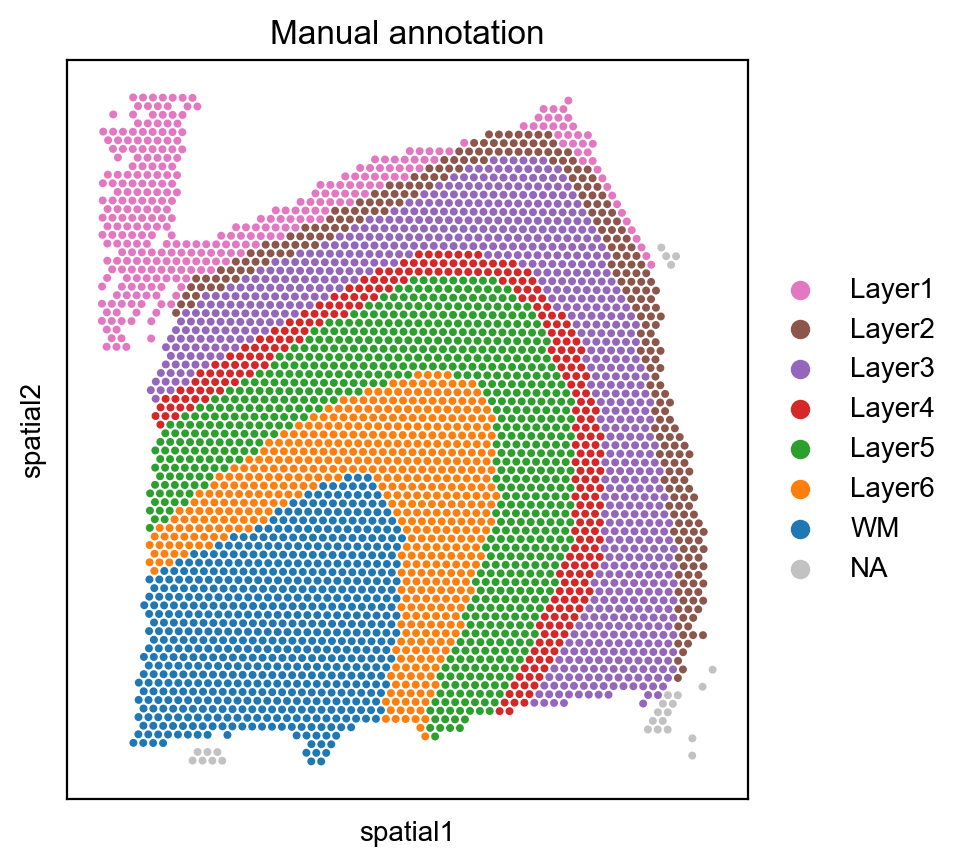

<Figure size 640x480 with 0 Axes>

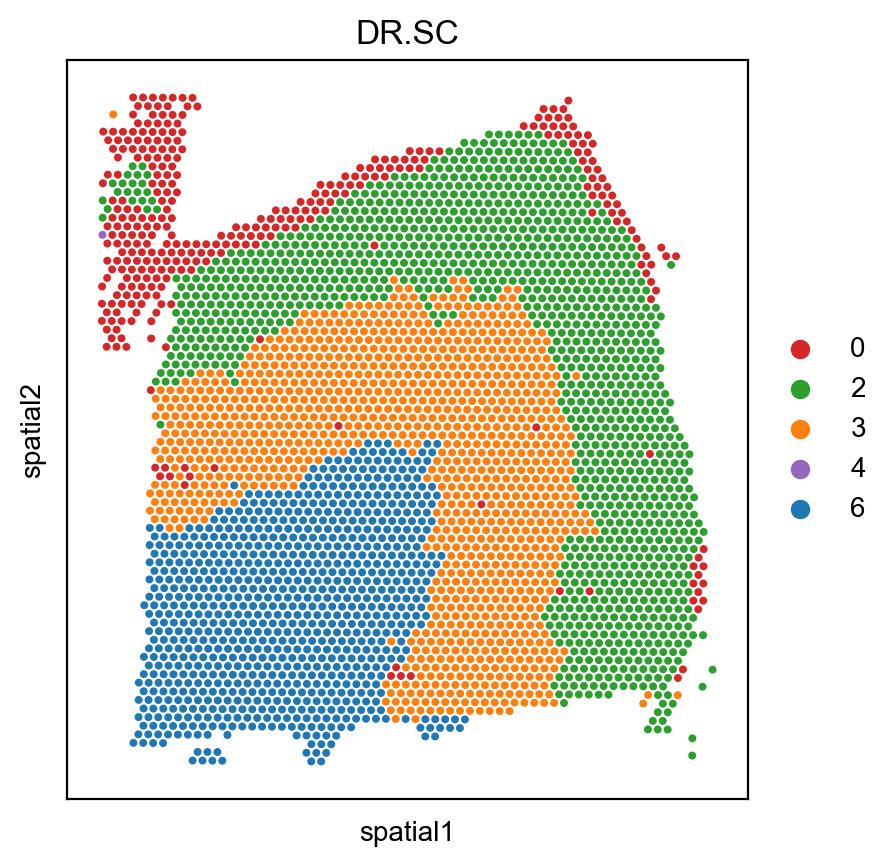

<Figure size 640x480 with 0 Axes>

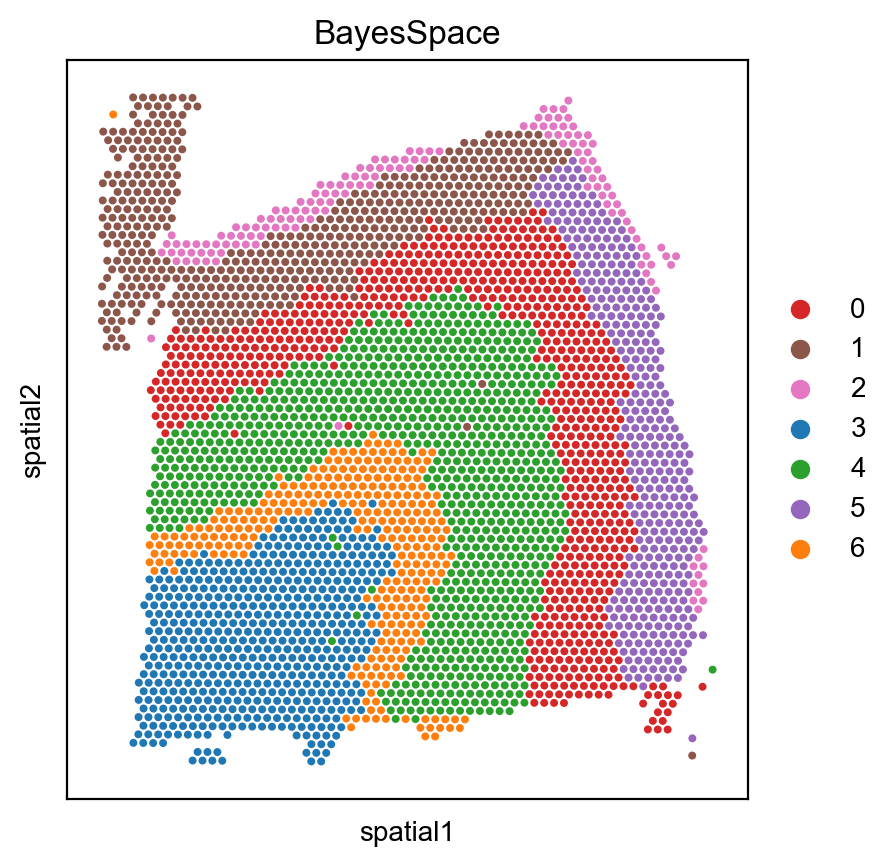

<Figure size 640x480 with 0 Axes>

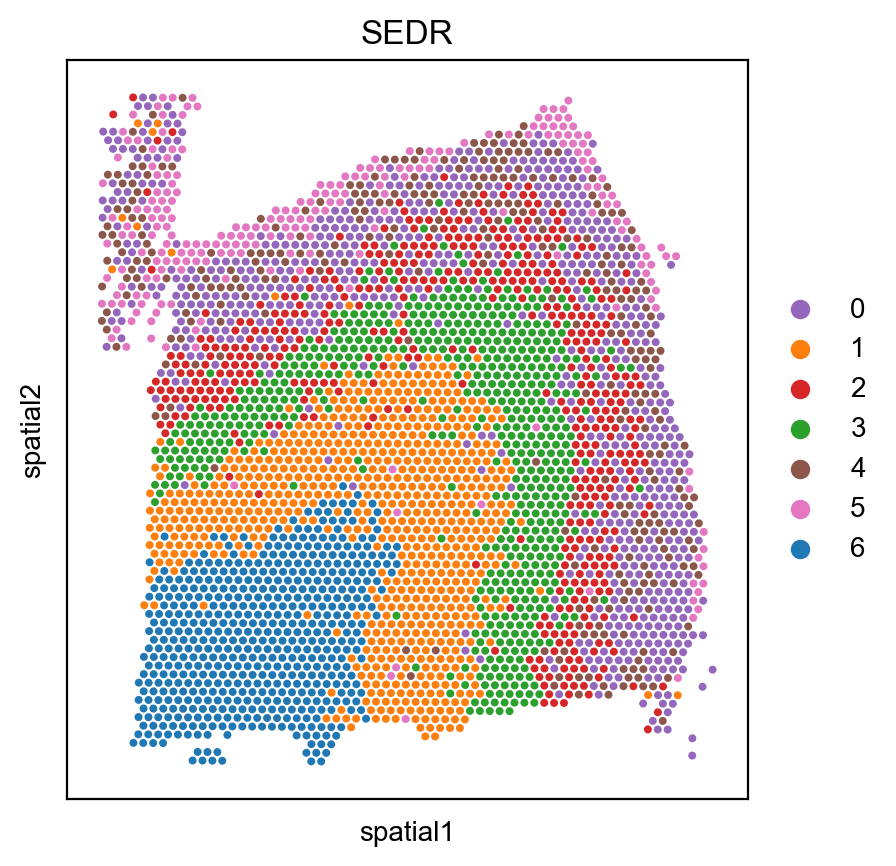

<Figure size 640x480 with 0 Axes>

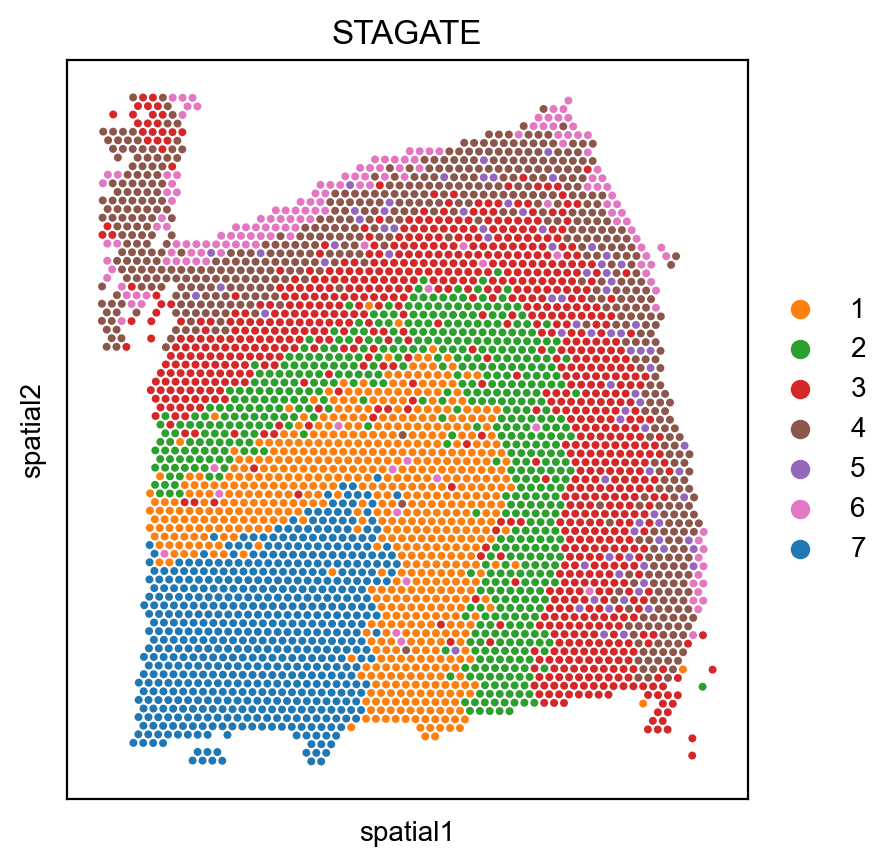

<Figure size 640x480 with 0 Axes>

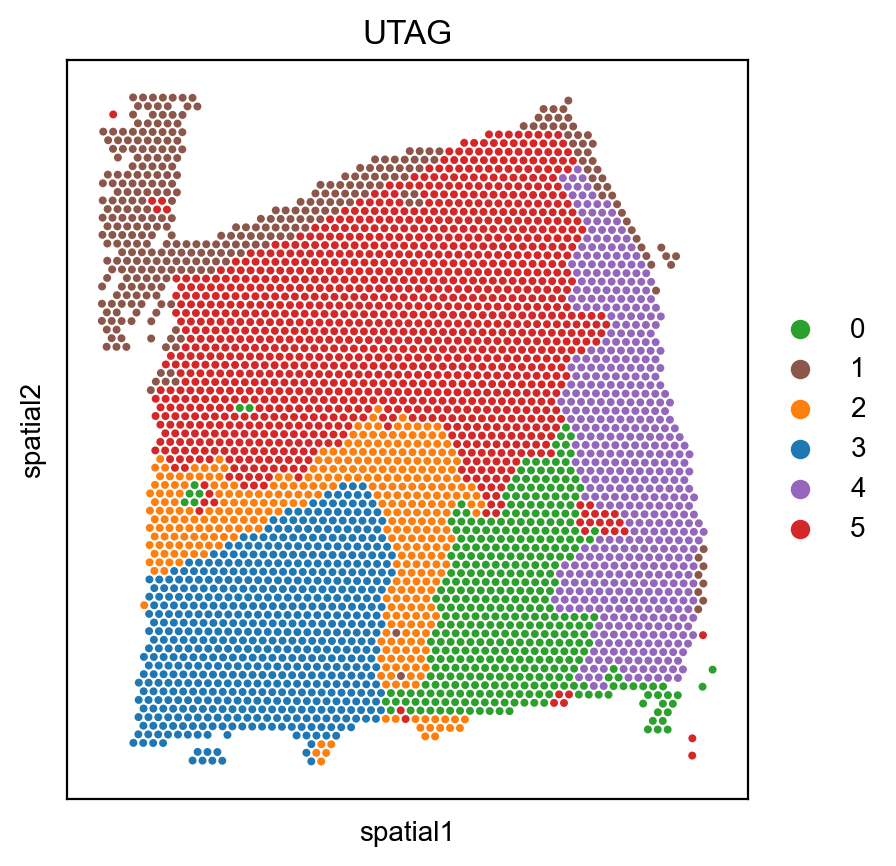

<Figure size 640x480 with 0 Axes>

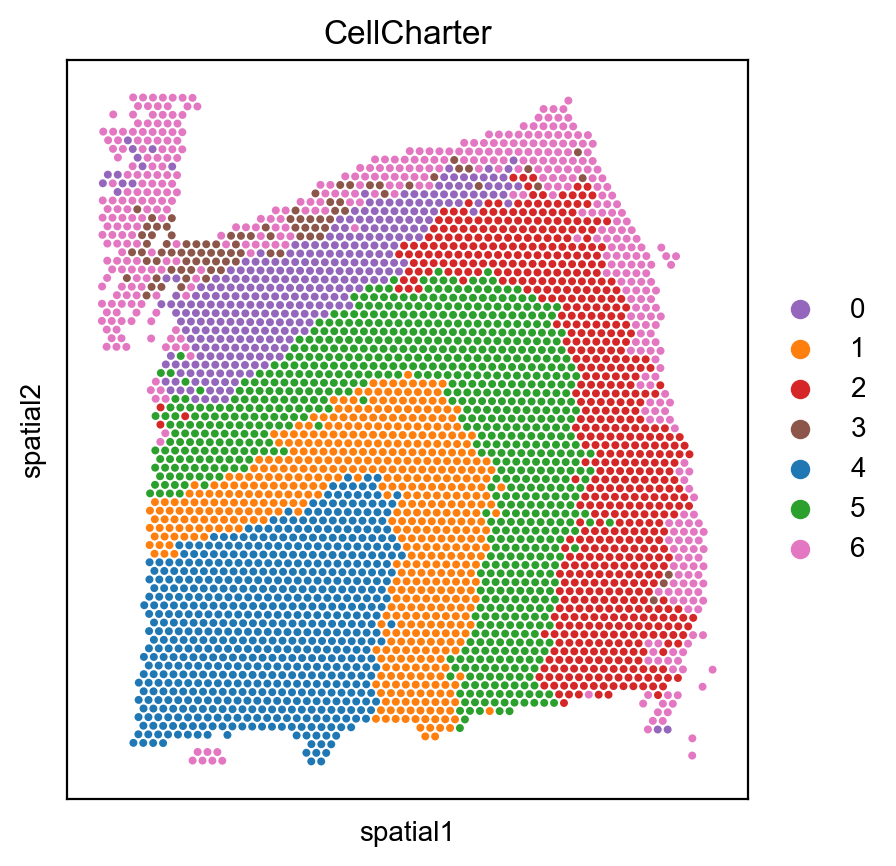

In [37]:
ax = sc.pl.spatial(
    adata, 
    palette={l: cm.get_cmap('tab10')(LABELS_REPLACEMENTS['Manual annotation'][l]) for l in adata.obs['Manual annotation'].cat.categories}, 
    color='Manual annotation',
    return_fig=True, 
    show=False, 
    size=1.15,
    scale_factor=800,
    na_color='#C2C2C2',
    title='Manual annotation',
)
plt.show()
plt.clf()

for method, path in LABELS_PATHS.items():
    ax = sc.pl.spatial(
        adata, 
        palette={l: cm.get_cmap('tab10')(LABELS_REPLACEMENTS[method][l]) for l in adata.obs[method].cat.categories}, 
        color=method,
        return_fig=True, 
        show=False, 
        size=1.15,
        scale_factor=800,
        na_color='#C2C2C2',
        title=method,
    )
    plt.show()
    plt.clf()

### Figure 1f

In [38]:
labels_batch = pd.read_csv('results/visium_human_dlpfc/labels/labels_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_joint.csv', index_col=0)
labels_nobatch = pd.read_csv('results/visium_human_dlpfc/labels/labels_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_joint_nobatchremoval.csv', index_col=0)

In [39]:
def plot_proportion(labels, group_key='sample', label_key='cluster_0'):
    labels[label_key] = pd.Categorical(labels[label_key])
    df = pd.pivot(labels[[group_key, label_key]].value_counts().reset_index(), index=group_key, columns=label_key)
    df[df.isna()] = 0
    df.columns = df.columns.droplevel(0)
    df = df.div(df.sum(axis=1), axis=0)
    df = df[df.columns[::-1]]
    ax = df.plot.bar(stacked=True, ax=plt.gca(), color=cm.get_cmap('tab10').colors[:len(labels[label_key].cat.categories)][::-1])
    ax.grid(False)

    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles[::-1], labels[::-1], loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))
    plt.show()

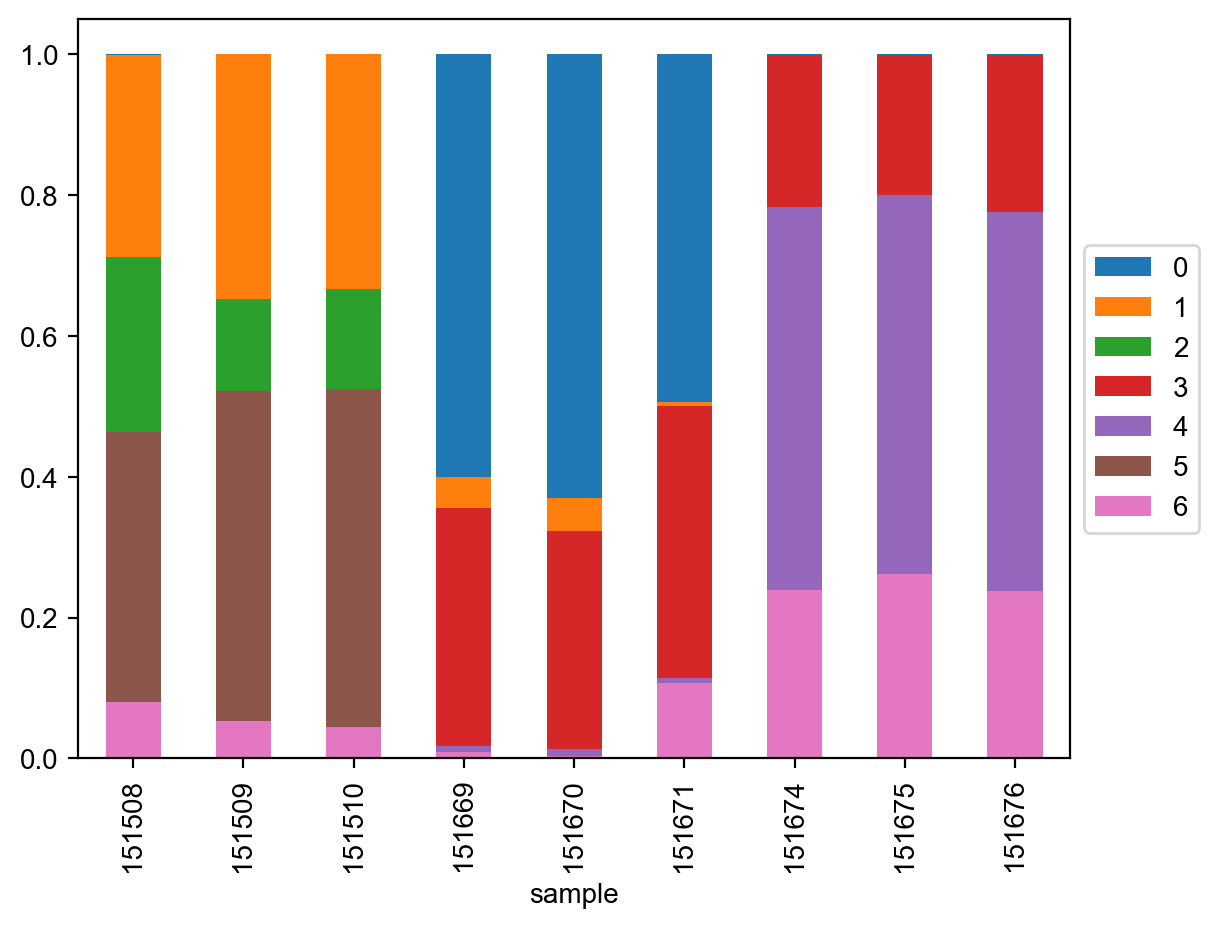

In [40]:
plot_proportion(labels_nobatch)

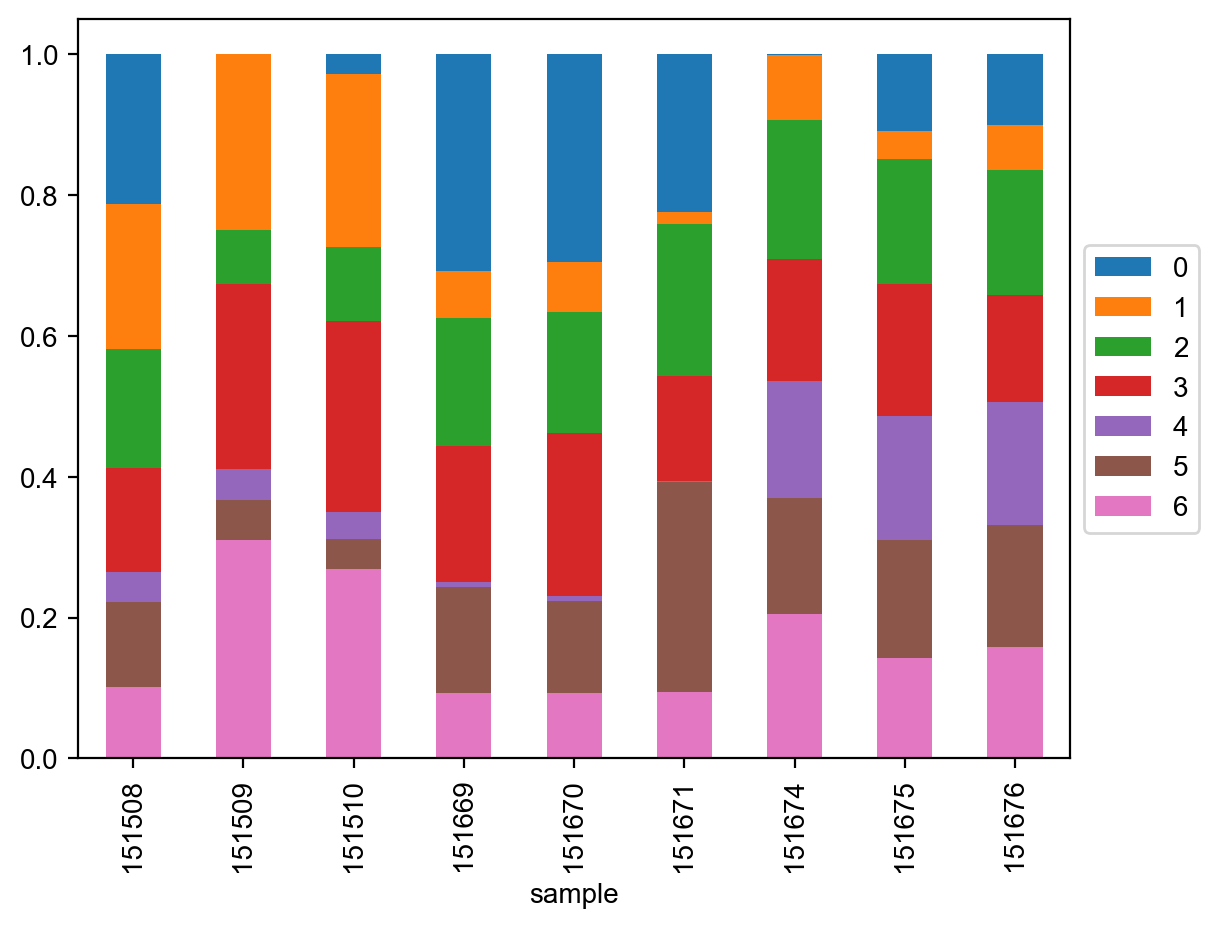

In [41]:
plot_proportion(labels_batch)

### Figure 1g

In [42]:
BASE_PATH = 'results/visium_human_dlpfc'

In [43]:
cc_accuracies = []
for fraction in [0.01,0.1, 0.25, 0.5, 0.75, 1.0]:
    if fraction != 1.0:
        acc = pd.read_csv(os.path.join(BASE_PATH, 'joint_downsampled', f'ARI_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_joint_downsampled{fraction}.csv'), index_col=0)
    else:
        acc = pd.read_csv(os.path.join(BASE_PATH, 'joint', f'ARI_CellCharter_hvgs5000_nlatent5_nhoodlayers4_gpu_joint.csv'), index_col=0)
    
    acc=pd.DataFrame(acc.mean(axis=1), columns=['Mean Aggregated ARI'])
    #acc = pd.melt(acc, value_name='ARI')
    acc['Downsampling'] = fraction
    acc['Method'] = 'CellCharter'
    cc_accuracies.append(acc)
cc_accuracies = pd.concat(cc_accuracies)

In [44]:
sg_accuracies = []
for fraction in [0.01,0.1, 0.25, 0.5, 0.75,  1.0]:
    if fraction != 1.0:
        acc = pd.read_csv(os.path.join(BASE_PATH, 'joint_downsampled', f'ARI_STAGATE_hvgs5000_hidden_dim1024_nlatent30_gpu_joint_downsampled{fraction}.csv'), index_col=0)
    else:
        acc = pd.read_csv(os.path.join(BASE_PATH, 'joint', f'ARI_STAGATE_hvgs5000_hidden_dim1024_nlatent30_gpu_joint.csv'), index_col=0)
    
    acc=pd.DataFrame(acc.mean(axis=1), columns=['Mean Aggregated ARI'])
    acc['Downsampling'] = fraction
    acc['Method'] = 'STAGATE'
    sg_accuracies.append(acc)
sg_accuracies = pd.concat(sg_accuracies)

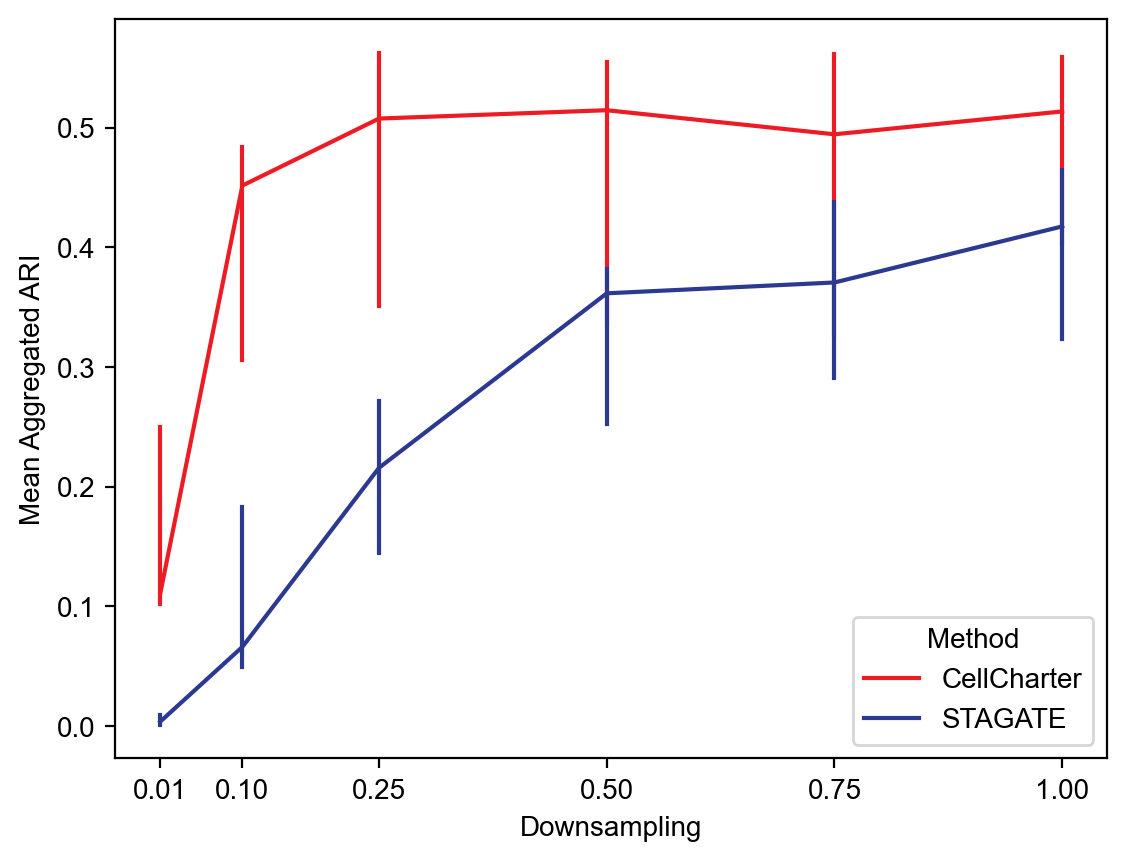

In [45]:
plt.clf()
sns.lineplot(data=pd.concat([cc_accuracies, sg_accuracies]), x='Downsampling', y='Mean Aggregated ARI', hue='Method', estimator='median', err_style="bars", palette=[PALETTE_METHOD[method] for method in ['CellCharter', 'STAGATE']])
plt.xticks([0.01, 0.1, 0.25, 0.5, 0.75, 1.0])
plt.show()

### Figure 1h

In [46]:
autok_pilot = cc.tl.ClusterAutoK.load('data/visium_human_dlpfc/DLPFC_pilot_hvgs5000_nlatent5_batch-patient_nhood4_autok_runs10')

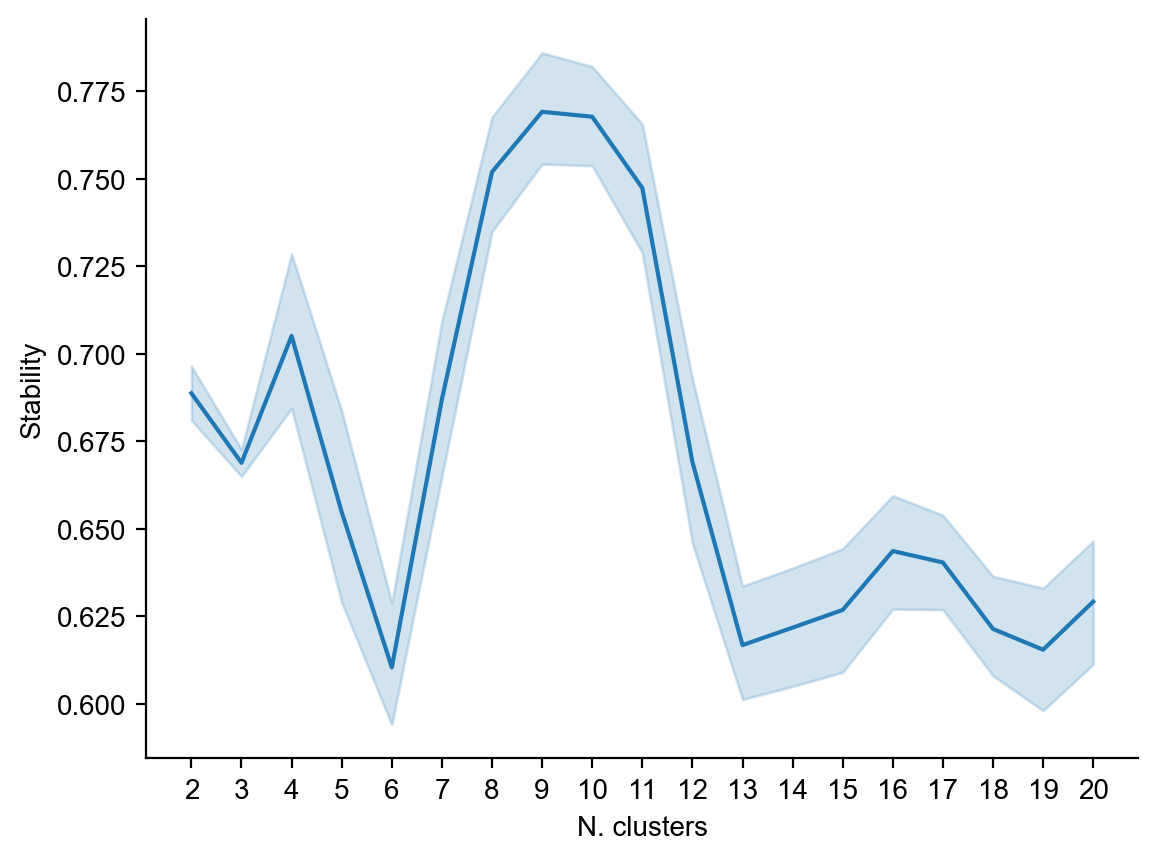

In [47]:
cc.pl.autok_stability(autok_pilot)
plt.show()

In [48]:
autok_full = cc.tl.ClusterAutoK.load('data/visium_human_dlpfc/DLPFC_full_hvgs5000_nlatent5_batch-study-patient_nhood4_autok_runs10')

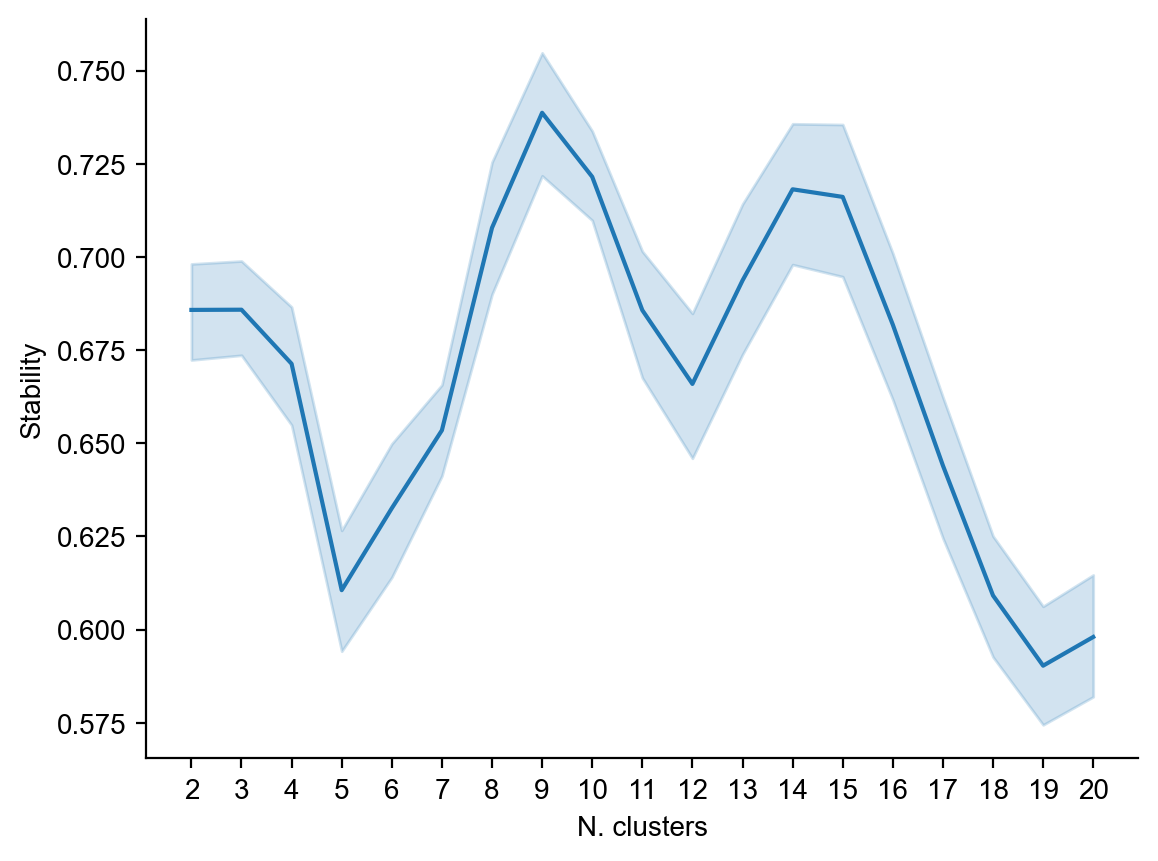

In [49]:
cc.pl.autok_stability(autok_full)
plt.show()